In [203]:
import config

ModuleNotFoundError: No module named 'config'

In [205]:
import configparser
config  = configparser.ConfigParser()
config.read('config.ini')
config.port()

AttributeError: 'ConfigParser' object has no attribute 'port'

In [1]:
# Connect to MariaDB Platform
# Module Imports
import mariadb
import sys

try:
    conn = mariadb.connect(
        user="USR",
        password="PASS",
        host="192.168.0.101",
        port=3306,
        database="homeassistant"

    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

# Get Cursor
cur = conn.cursor()

## Prepare SQL query cmd

In [148]:
import datetime
sensor_code = "6f01be05" # main_farm  # CO2 exp: a1578703
features = ["entity_id", "state", "last_updated"]
base_cmd = f'select {", ".join(features)} from states where'
data_types = ["carbon_dioxide_concentration", "humidity", "temperature"]

t_begin_unix = 1649674801
t_end_unix =   1650279601

t_begin = str(datetime.datetime.fromtimestamp(t_begin_unix).strftime('%Y-%m-%d %H:%M:%S'))
t_end = str(datetime.datetime.fromtimestamp(t_end_unix).strftime('%Y-%m-%d %H:%M:%S'))
print("Begin: ",t_begin)
print("End: ",t_end)

Begin:  2022-04-11 13:00:01
End:  2022-04-18 13:00:01


Combine the proper SQL query

In [149]:
entity_cmd_list = []
for data_type in data_types:
    entity_cmd_list.append(f'entity_id like "%{sensor_code}_{data_type}%"')
entity_cmd = "(" +  ' or '.join(entity_cmd_list) + ")"
full_cmd = f"{base_cmd} {entity_cmd} and last_updated <='{t_end}' and last_updated >='{t_begin}'" 

In [150]:
full_cmd

'select entity_id, state, last_updated from states where (entity_id like "%6f01be05_carbon_dioxide_concentration%" or entity_id like "%6f01be05_humidity%" or entity_id like "%6f01be05_temperature%") and last_updated <=\'2022-04-18 13:00:01\' and last_updated >=\'2022-04-11 13:00:01\''

In [151]:
cur.execute(full_cmd)
vals = [_ for _ in cur]

In [153]:
import pandas as pd
import numpy as np
df_home = pd.DataFrame.from_records(vals, columns=features)
df_home["time_s"] = df_home["last_updated"].apply(lambda x: np.int64(pd.to_datetime(x).timestamp())) 

Read data from Atlatics

## Load atlatics data

In [154]:
df_at = pd.read_csv("feeds-main-farm.csv", names=["time", "id", "ph", "EC", "water_T", "lat", "longi", "elevation", "status"])
df_at = df_at.drop(["id","lat","longi","elevation","status"], axis=1) # delete redundant columns
df_at = df_at.drop([0], axis=0) # delete the name filed
df_at["time_s"] = df_at.time.apply(lambda x: np.int64(pd.to_datetime(x).timestamp())) # convert to unix time step
df_at[["ph", "EC", "water_T"]] = df_at[["ph", "EC", "water_T"]].apply(pd.to_numeric) # conver to numeric value

/home/hexaburbach/anaconda3/envs/analysis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [155]:
df_home["sensor"] = df_home.entity_id.str.split('_').str[-1]
df_home.sensor[df_home.sensor=="concentration"] = "CO2" # change name of sensor type
df_home.sensor[df_home.sensor=="temperature"] = "air_T" # change name of sensor type
df_home.state = df_home.state.astype(np.float16)

/tmp/ipykernel_1160947/1992619237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.sensor[df_home.sensor=="concentration"] = "CO2" # change name of sensor type
/tmp/ipykernel_1160947/1992619237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.sensor[df_home.sensor=="temperature"] = "air_T" # change name of sensor type


## Create columns for features

In [156]:
df_home = pd.get_dummies(df_home, columns=['sensor'])
df_home.sensor_CO2 = df_home.sensor_CO2 * df_home.state
df_home.sensor_humidity = df_home.sensor_humidity * df_home.state
df_home.sensor_air_T = df_home.sensor_air_T * df_home.state

## Filter data frames

In [157]:
df_home[["sensor_CO2", "sensor_humidity", "sensor_air_T"]] = df_home[["sensor_CO2", "sensor_humidity", "sensor_air_T"]].replace({'0':np.nan, 0:np.nan})
df_at_fit = df_at[(df_at.time_s>t_begin_unix)  & (df_at.time_s<t_end_unix)]

## Load area files

In [193]:
GROW_FILE = 'hexa_volume6.csv'
df_grow = pd.read_csv(GROW_FILE)
df_grow['time_s'] = df_grow['file_name'].apply(lambda x: x.split('-')[-1].split('.')[0]).astype(np.int64)
df_grow = df_grow.drop("file_name", axis=1)

## Merge different data frames

In [194]:
from functools import reduce
df_merge = reduce(lambda left, right: pd.merge(left, right, how="outer", on="time_s"), [df_home, df_at_fit, df_grow])
df_merge = df_merge.drop(["entity_id", "state", "last_updated", "time"], axis=1)
df_merge.head(10)

,time_s,sensor_CO2,sensor_air_T,sensor_humidity,ph,EC,water_T,area_cm2,volume_cm3
0,1649682040,NaN,NaN,33.593750,NaN,NaN,NaN,NaN,NaN
1,1649682101,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1649682222,NaN,NaN,34.812500,NaN,NaN,NaN,NaN,NaN
3,1649682312,NaN,NaN,35.812500,10.21,1426.0,18.53,NaN,NaN
4,1649682343,NaN,NaN,34.406250,NaN,NaN,NaN,NaN,NaN
5,1649682373,NaN,NaN,33.312500,NaN,NaN,NaN,NaN,NaN
6,1649682373,398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1649682433,NaN,NaN,34.906250,NaN,NaN,NaN,NaN,NaN
8,1649682494,NaN,NaN,33.093750,NaN,NaN,NaN,NaN,NaN
9,1649682524,NaN,NaN,31.703125,NaN,NaN,NaN,NaN,NaN


## Process NaN values

In [195]:
df_merge = df_merge.interpolate('linear', limit_direction='both')
df_merge.head(10)

,time_s,sensor_CO2,sensor_air_T,sensor_humidity,ph,EC,water_T,area_cm2,volume_cm3
0,1649682040,398.000000,19.000000,33.593750,10.210000,1426.000000,18.530000,110.0,125.0
1,1649682101,398.000000,19.000000,34.203125,10.210000,1426.000000,18.530000,110.0,125.0
2,1649682222,398.000000,19.014509,34.812500,10.210000,1426.000000,18.530000,110.0,125.0
3,1649682312,398.000000,19.029018,35.812500,10.210000,1426.000000,18.530000,110.0,125.0
4,1649682343,398.000000,19.043527,34.406250,10.211646,1426.037975,18.535823,110.0,125.0
5,1649682373,398.000000,19.058036,33.312500,10.213291,1426.075949,18.541646,110.0,125.0
6,1649682373,398.000000,19.072545,34.109375,10.214937,1426.113924,18.547468,110.0,125.0
7,1649682433,398.166667,19.087054,34.906250,10.216582,1426.151899,18.553291,110.0,125.0
8,1649682494,398.333333,19.101562,33.093750,10.218228,1426.189873,18.559114,110.0,125.0
9,1649682524,398.500000,19.116071,31.703125,10.219873,1426.227848,18.564937,110.0,125.0


In [196]:
df_merge.describe()

,time_s,sensor_CO2,sensor_air_T,sensor_humidity,ph,EC,water_T,area_cm2,volume_cm3
count,1.182700e+04,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000,11827.000000
mean,1.649856e+09,408.565951,19.073427,37.687710,11.289975,1199.626871,19.164916,110.025619,125.025197
std,1.398991e+05,31.768524,0.651477,9.394481,1.353284,183.819511,1.015366,1.227374,1.718683
min,1.649675e+09,358.000000,15.796875,26.000000,9.460000,0.000000,16.890000,61.000000,52.000000
25%,1.649752e+09,398.000000,19.093750,32.906250,10.190000,1084.978851,18.408770,110.000000,125.000000
50%,1.649829e+09,398.000000,19.093750,32.906250,11.040000,1221.000000,19.210000,110.000000,125.000000
75%,1.649911e+09,398.000000,19.093750,36.812500,12.120000,1375.000000,20.040000,110.000000,125.000000
max,1.650280e+09,686.000000,21.093750,66.687500,13.960000,1434.000000,20.920000,171.000000,217.000000


## Create relative time
This is time starting from the beginning of the batch

<AxesSubplot:xlabel='time_rel'>

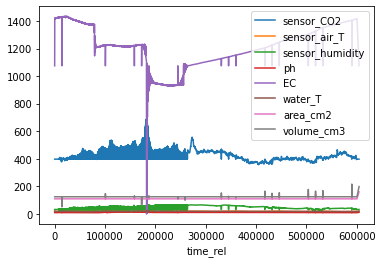

In [197]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
df_merge["time_rel"] = df_merge.time_s - df_merge.time_s.min()
df_merge = df_merge.sort_values(by="time_rel")
df_merge = df_merge.drop("time_s", axis=1).set_index("time_rel")
df_merge.plot()

## Normalize values

<AxesSubplot:xlabel='time_rel'>

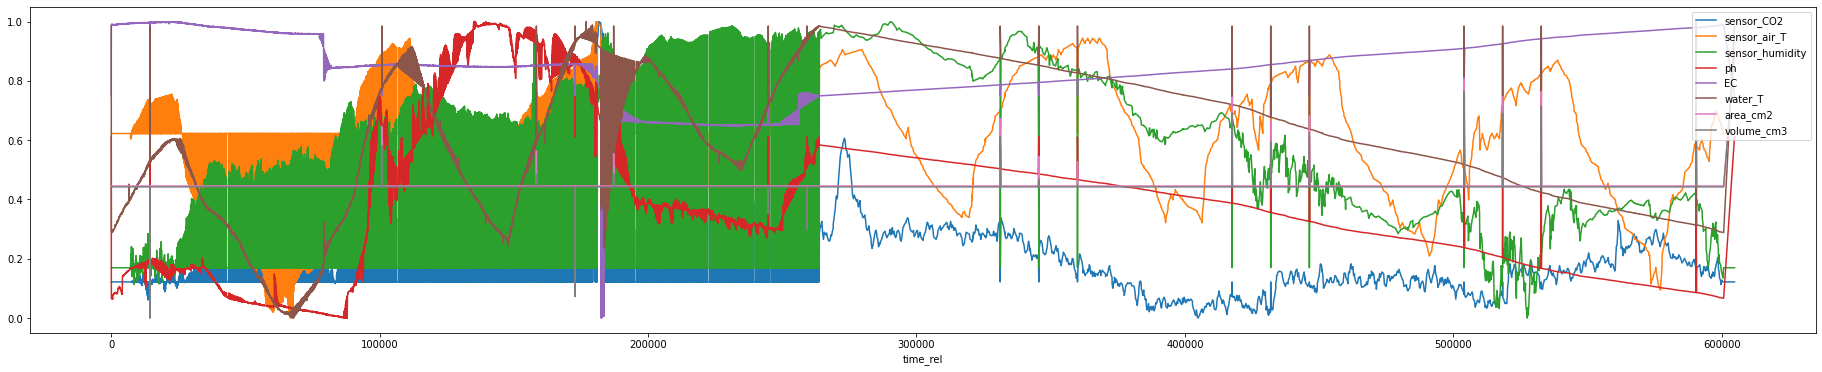

In [198]:
scaler = MinMaxScaler()
df_merge_scaled = pd.DataFrame(scaler.fit_transform(df_merge), columns=df_merge.columns, index=df_merge.index)
df_merge_scaled.plot(figsize=(32, 6))

## Correlation map

In [202]:
corr = df_merge_scaled.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').set_precision(2)

/tmp/ipykernel_1160947/1971660252.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').highlight_null(null_color='#f1f1f1').set_precision(2)
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/hexaburbach/.local/lib/python3.8/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,sensor_CO2,sensor_air_T,sensor_humidity,ph,EC,water_T,area_cm2,volume_cm3
sensor_CO2,nan,nan,nan,nan,nan,nan,nan,nan
sensor_air_T,0.08,nan,nan,nan,nan,nan,nan,nan
sensor_humidity,0.70,0.07,nan,nan,nan,nan,nan,nan
ph,0.13,0.15,0.07,nan,nan,nan,nan,nan
EC,-0.07,-0.12,-0.11,-0.29,nan,nan,nan,nan
water_T,0.15,0.31,0.26,0.46,-0.50,nan,nan,nan
area_cm2,-0.01,0.00,-0.01,0.01,-0.01,0.03,nan,nan
volume_cm3,-0.00,0.00,-0.01,0.01,-0.01,0.02,0.98,nan
